In [1]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

plt.rcParams["font.size"] = 14
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
figs = [20,50]
fign = [15,4]

In [2]:
from pymongo import MongoClient

In [3]:
# client = MongoClient('localhost', 27017)
# db = client.adsE_database
# collection = db.adsE_method2

### prepare data for prediction ###

In [4]:
formulas = ['Ag', 'Al', 'Au', 'Cu', 'Pt', 'Pd', 'Ni', 'Rh']
faces = ['100', '111', '110', '211']

dictlis = []

for ele in formulas:
    for face in faces:
        dicte = {'formula':ele, 'face':face}
        dictlis.append(dicte)

dictlis.append({'formula':'Ru', 'face':'001'})
dictlis.append({'formula':'Ru', 'face':'100'})
dictlis.append({'formula':'Zn', 'face':'001'})
dictlis.append({'formula':'Zn', 'face':'100'})

dictlis.append({'formula':'ZnCu', 'face':'100'})
dictlis.append({'formula':'ZnCu', 'face':'110'})
dictlis.append({'formula':'CuSn', 'face':'100'})
dictlis.append({'formula':'CuSn', 'face':'001'})
dictlis.append({'formula':'CoPt3', 'face':'100'})
dictlis.append({'formula':'GaNi', 'face':'110'})

In [5]:
inst = []
dfall = []
df = []
dfpred = []
dfpred_onlyformula = []

for i in range(len(dictlis)):
    try:
        du = dataset_utilizer('adsE_method2_new', **dictlis[i])
        inst.append(du)
        dfall.append(du.dfall)
        df.append(du.df)
        dfpred.append(du.dfpred)
        dfpred_onlyformula.append(du.dfpred_onlyformula)
    except:
        print('Error: {0}'.format(dictlis[i]))

In [6]:
covset = []
for i in range(len(dfpred)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
# covset

### Just show residue ####

Ag 100 0.023114000731727445
Ag 111 0.10886186060998215
Ag 110 0.042249667112556996
Ag 211 0.027067921648881603
Al 100 0.03852199125056321
Al 111 0.07242035334292324
Al 110 0.021740933264406334
Al 211 0.0883412477136706
Au 100 0.06090423048770582
Au 111 0.2354275561288555
Au 110 0.04415361057546584
Au 211 0.007164910000000191
Cu 100 0.08283242518379592
Cu 111 0.10006175960064963
Cu 110 0.08708137077435905
Cu 211 0.009807183333328126
Pt 100 0.17901315150314273
Pt 111 0.22181467459511078
Pt 110 0.24851202945361564
Pt 211 0.05446614306077099
Pd 100 0.19773032868392085
Pd 111 0.19252600819756988
Pd 110 0.20406265528622422
Pd 211 0.040172089658565883
Ni 100 0.10614268850265127
Ni 111 0.11136314970368909
Ni 110 0.07020906175613738
Ni 211 0.028580358732093733
Rh 100 0.07986399181400822
Rh 111 0.08916327310964357
Rh 110 0.09861413750350091
Rh 211 0.07874043834738319
Ru 001 0.08686146631528333
Ru 100 0.12333567935653712
Zn 100 0.09689093416182526
ZnCu 100 0.048116105713959585
ZnCu 110 0.19321083

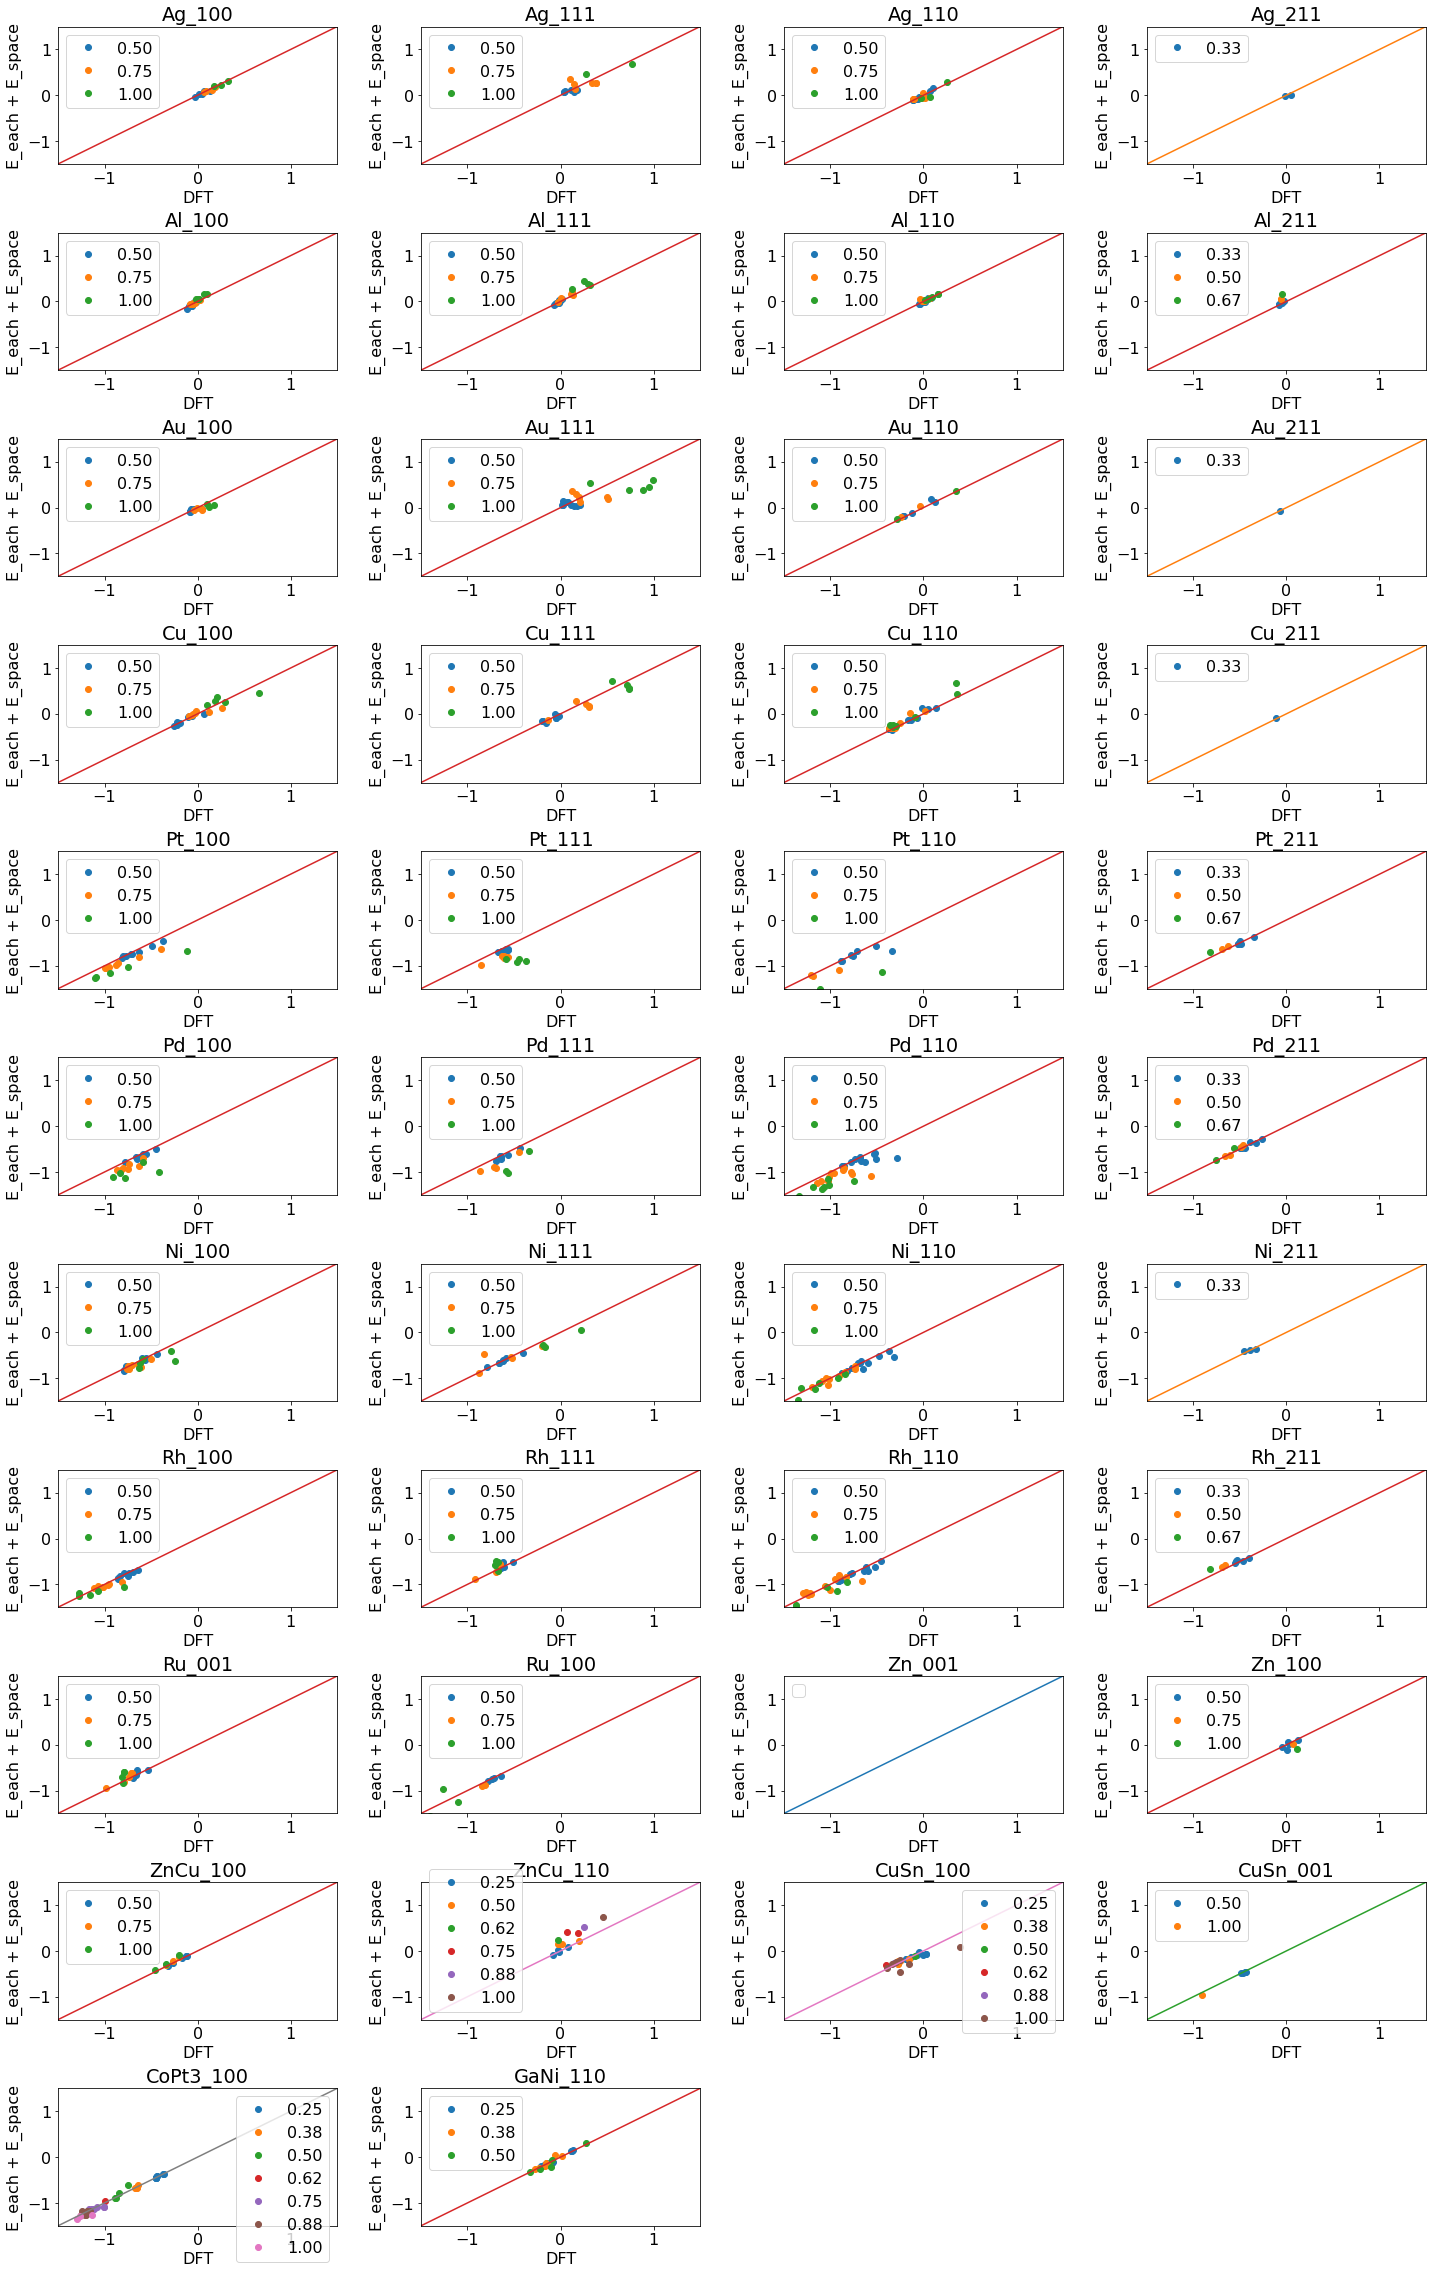

In [7]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(figs[0],figs[1]))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(fign[0],fign[1], i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        if not covset[i][j]:
            continue
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        aveadsE_suratom = np.array(data['aveadsE/suratom'])
        E_residue = np.array(data['E_residue/suratom'])
        E_prepred = aveadsE_suratom - E_residue
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_prepred, 'o')
   
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['formula'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
    if not covset[i]:
        continue
    data = dfpred[i]
    aveadsE_suratom = np.array(data['aveadsE/suratom'])
    E_residue = np.array(data['E_residue/suratom'])
    E_prepred = aveadsE_suratom - E_residue    
    print(dictlis[i]['formula'], dictlis[i]['face'], np.sqrt(mean_squared_error(aveadsE_suratom, E_prepred)))
    
# plt.savefig('E_residue.png', bbox_inches='tight')
plt.show()

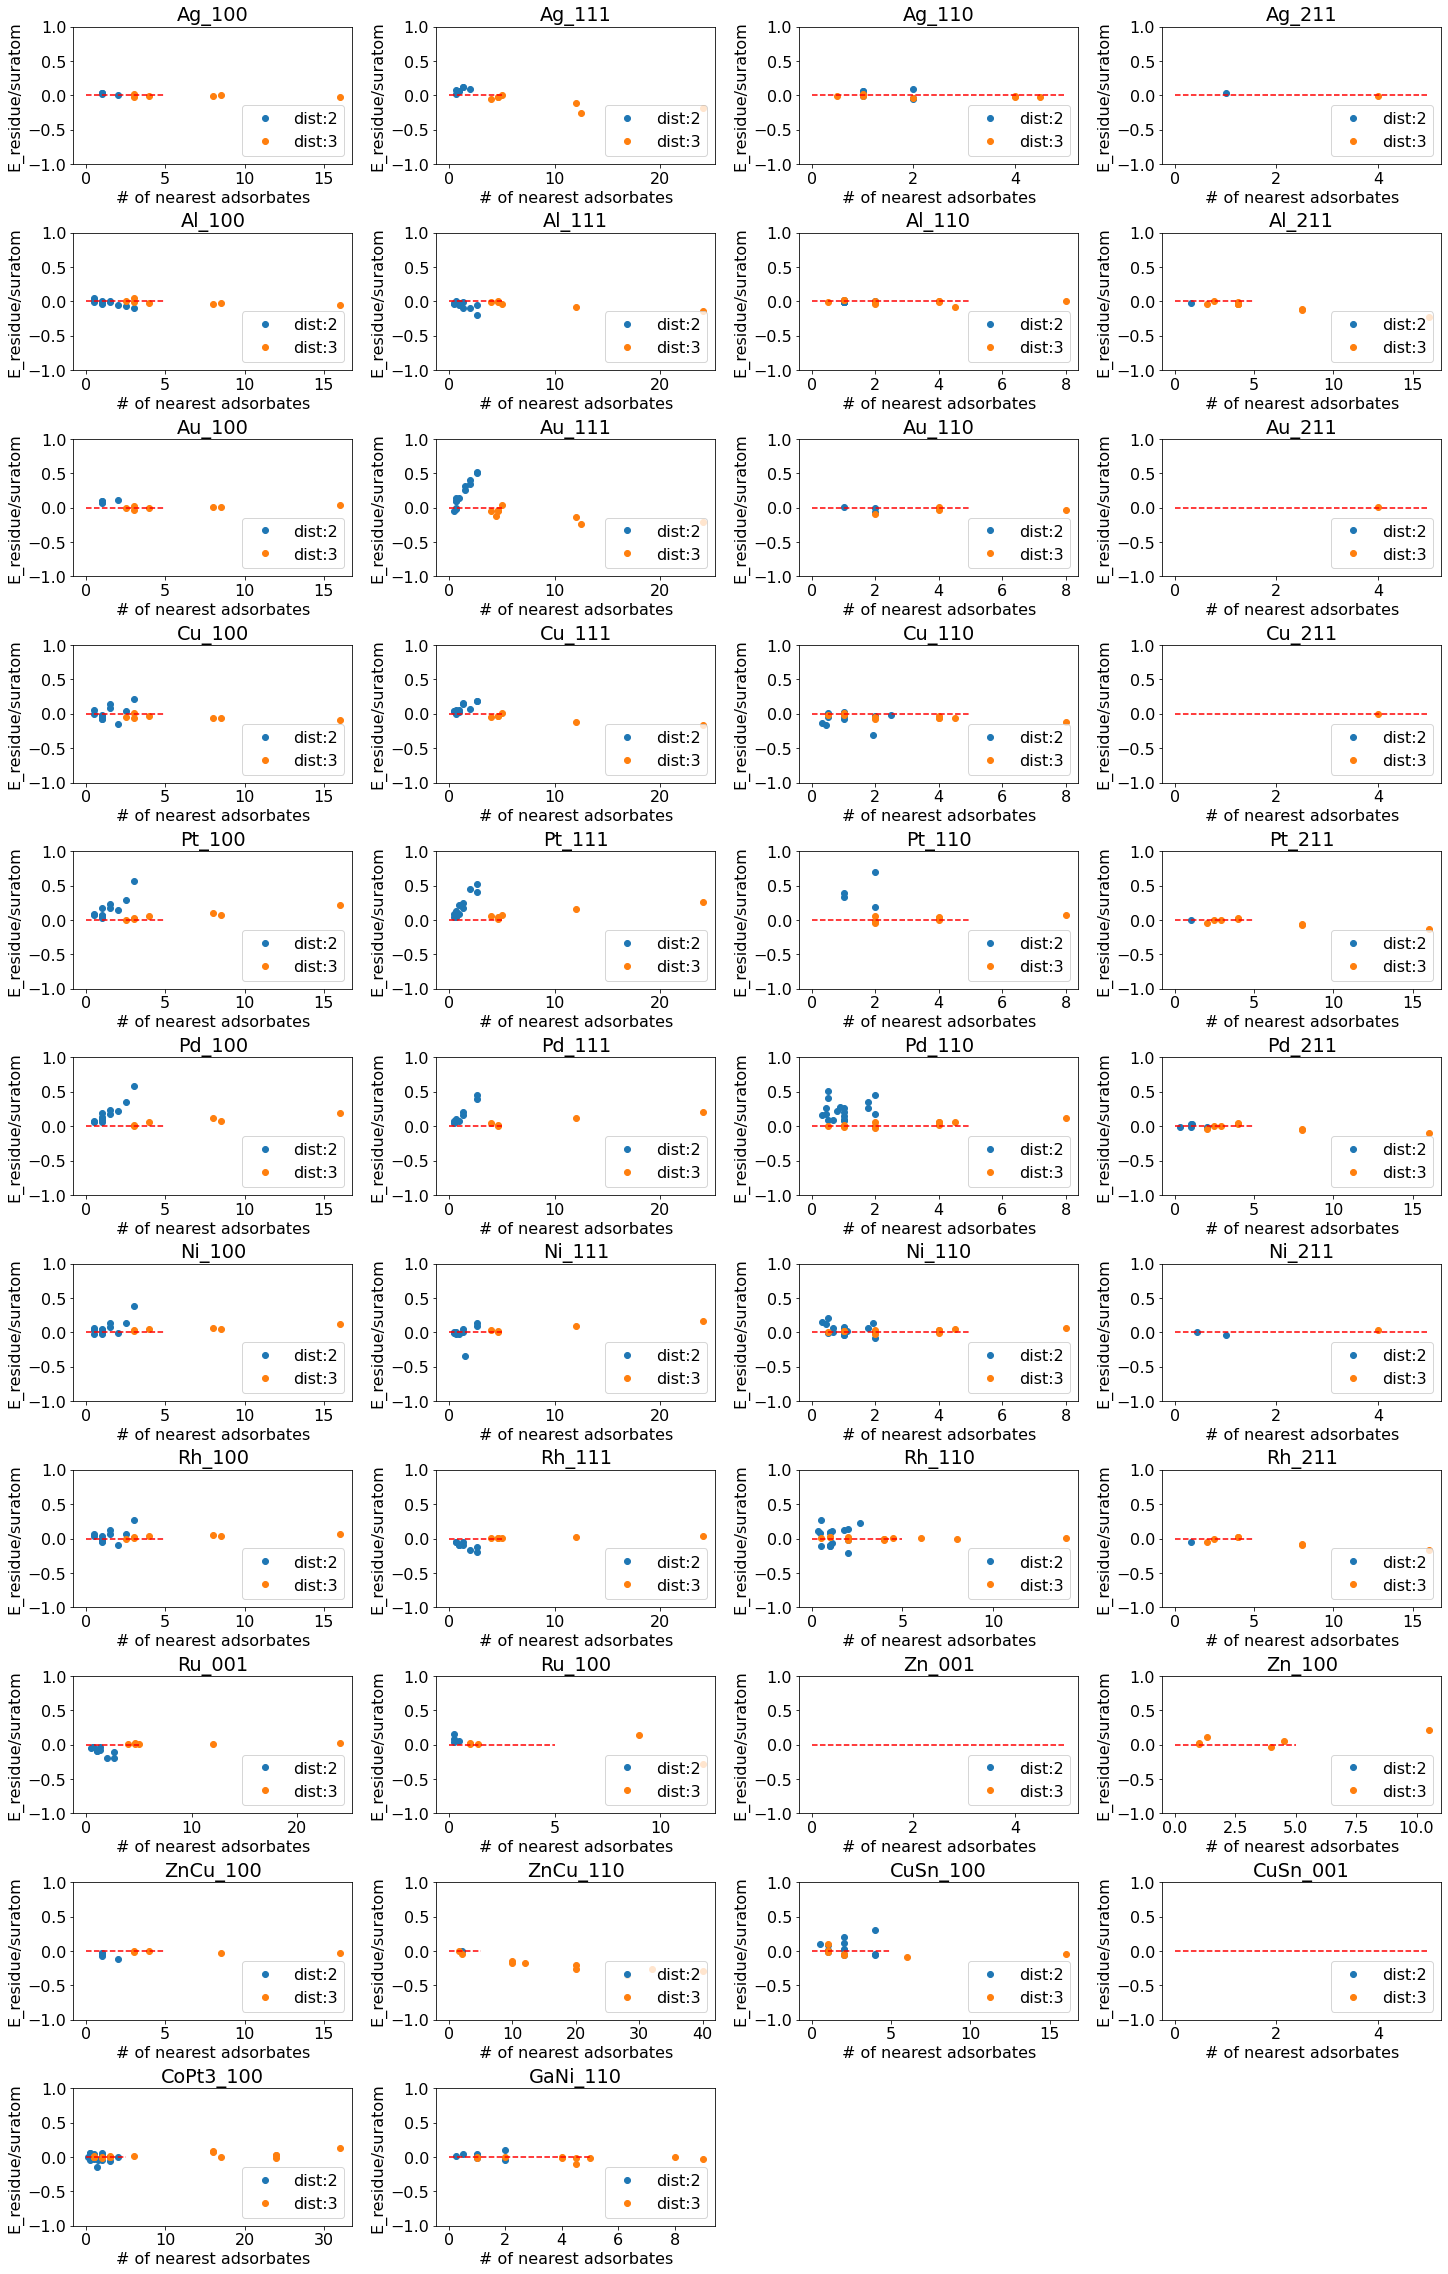

In [8]:
fig = plt.figure(figsize=(figs[0],figs[1]))
plt.rcParams["font.size"] = 16


xmin = 0
xmax = 5
for i in range(len(dfpred)):
    ax = fig.add_subplot(fign[0],fign[1], i+1)
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==2]['ads_dist2'], dfpred[i][dfpred[i]['minimum_distance']==2]['E_residue/suratom'], 'o')
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==3]['ads_dist3'], dfpred[i][dfpred[i]['minimum_distance']==3]['E_residue/suratom'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['formula'], dictlis[i]['face']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('E_residue/suratom')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'], loc='lower right')
# plt.savefig('')
  #  plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

### Parameters are specific to material and face

Ag 100 0.016539517845130147 0.0233927117155994 -0.0008789206455014601 0.00782224047592699 0.000807070854765492
Ag 111 0.04426761293461467 0.12451407733867072 -0.009218314970286377 0.017399233192246063 0.0014477718349590679
Ag 110 0.03883643844649586 0.01932469652376835 -0.004933245294878807 0.012043564970862265 0.003978922616080165
Ag 211 4.9065389333867974e-18 0.039434637499999585 -0.0020006741666670123 inf inf
Al 100 0.026472089489818558 -0.014527658416896221 -0.002316465259944394 0.006075023553006505 0.0011368053302188528
Al 111 0.035706023468853015 -0.02296416538007827 -0.004744422379048623 0.00915329868922716 0.001196188065575856
Al 110 0.02054457962159339 0.003089566395141241 -0.0021763628611737172 0.00674155534545942 0.0014629866491471715
Al 211 0.02273020915457539 -0.005935896287119918 -0.01297214371287955 0.025155671385438217 0.0011539177397613942


/home/katsuyut/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Au 100 0.01819817584803992 0.06459780506354719 0.0015253946514975658 0.008523990610741876 0.0008758404192893085
Au 111 0.0642715085938652 0.22742891095968554 -0.009505130288468581 0.015638628406850517 0.0018646279223920078
Au 110 0.03955850671721917 -0.010189459565575341 -0.0030556244631150453 0.0164457669847327 0.0038525959457237162
Au 211 0.0 0.0 0.0017912275000000477 nan nan
Cu 100 0.0575518370914955 0.048066716654456915 -0.010148742776864172 0.013416462661364948 0.0024818835857948734
Cu 111 0.029083740172890483 0.09607302339239782 -0.006610945307707783 0.007545359166907145 0.0009785293391816952
Cu 110 0.06877383510042046 -0.02751522619479267 -0.011462957128707946 0.015605613547146577 0.004720774983335328
Cu 211 0.0 0.0 -0.0024517958333320315 nan nan


/home/katsuyut/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/katsuyut/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Pt 100 0.07433064946879508 0.11017149937304889 0.006990273352604106 0.017327933105031345 0.0032054583860596834
Pt 111 0.041391753356969006 0.12682265471391224 0.010805922842364582 0.010490815812148474 0.00138131951292654
Pt 110 0.09309879507302654 0.20462491473765881 0.018683068755144517 0.03643942655176818 0.0072589075204021105
Pt 211 0.028900379166362674 0.011344665196712612 -0.006639770196720568 0.032807629732873815 0.0015719295326651445
Pd 100 0.062414242548746425 0.12653937577252983 0.007153614134334666 0.014615915108647837 0.002713707430386617
Pd 111 0.03134337346174101 0.12317735560228077 0.00815239010581285 0.008459237644908017 0.0011687982424497293
Pd 110 0.10169831442478496 0.1264196649796065 0.02297747304392094 0.02872455966988474 0.006569958864803445
Pd 211 0.026244879246473663 0.021714944843948383 -0.005141672704959929 0.011818991749327325 0.0013382372924507795
Ni 100 0.07167558055161366 0.05746312490254435 0.0021218941328557507 0.016686559782026 0.0031072545871182666
Ni 1

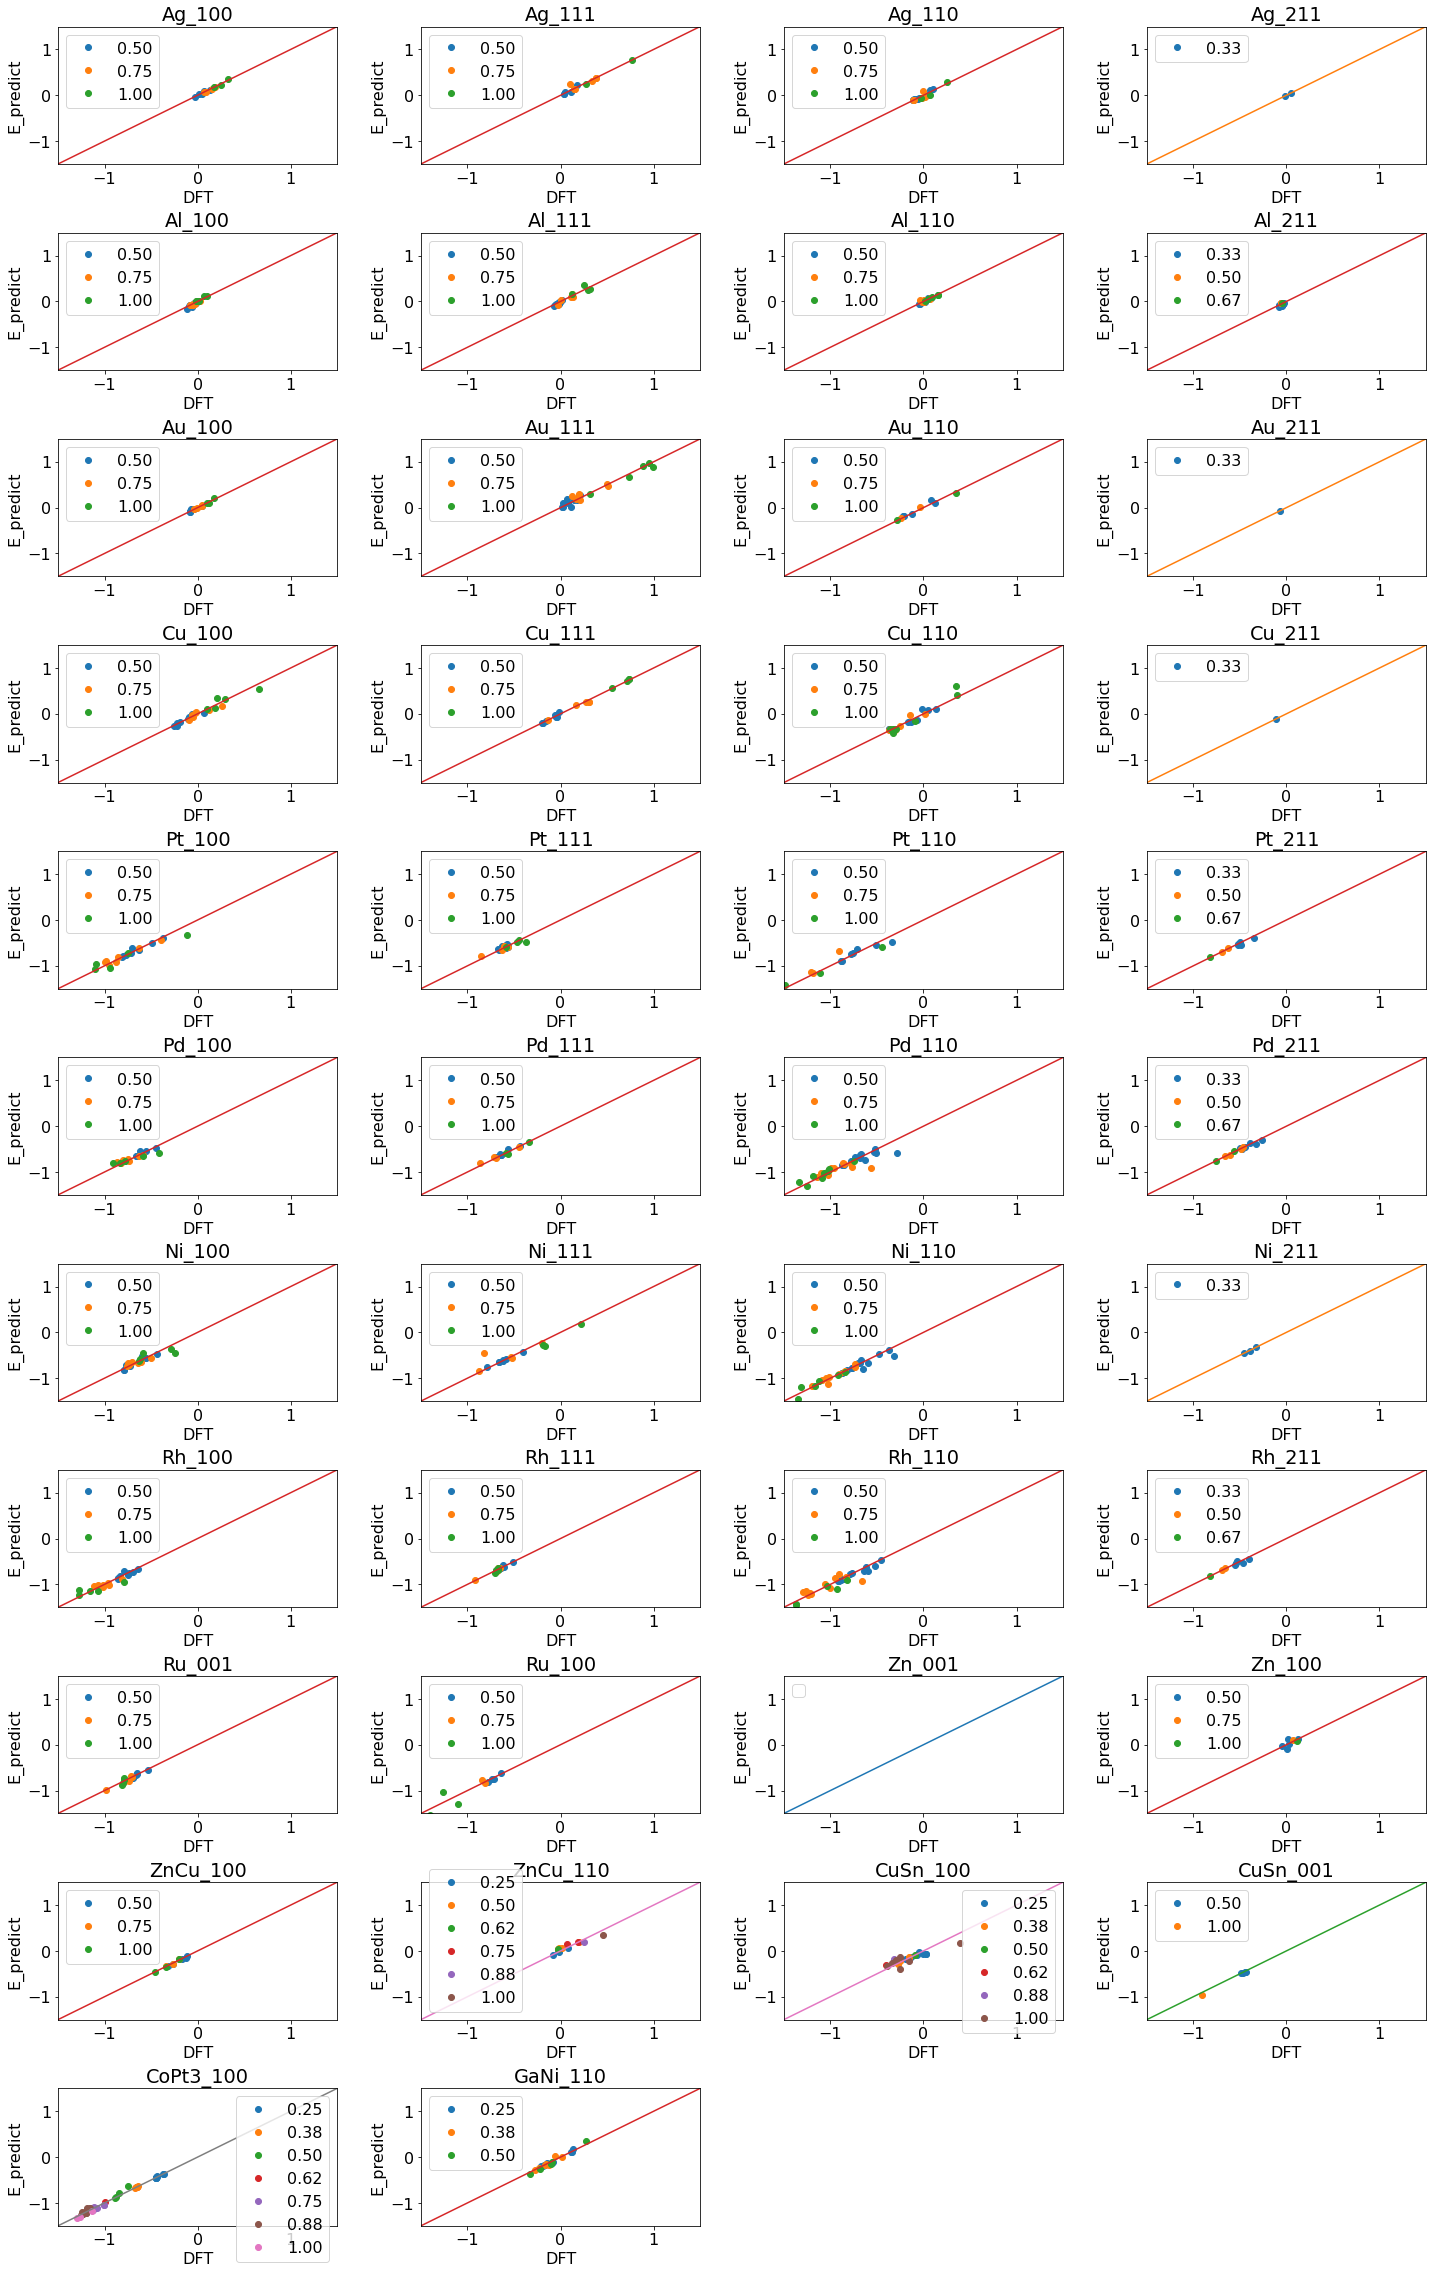

In [9]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(figs[0],figs[1]))
plt.rcParams["font.size"] = 16
mselis = []
weightslis = []
std_errslis = []

for i in range(len(dfpred)):
    ax = fig.add_subplot(fign[0],fign[1], i+1)
    xmin = 100
    xmax = -100
    try:
        weights, std_errs = inst[i].fit_weight_from_specific_formula_and_face()
        weightslis.append(weights)
        std_errslis.append(std_errs)
    except:
        weightslis.append(np.array([0,0]))
        std_errslis.append(np.array([0,0]))
        print('Data unusable')

    for j in range(len(covset[i])):
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]

        E_residue_pred = data['ads_dist2'] * weights[0] + data['ads_dist3'] * weights[1]
        E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

        aveadsE_suratom = data['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['formula'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_predict')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
    if not covset[i]:
        continue
    data = dfpred[i]
    E_residue_pred = data['ads_dist2'] * weights[0] + data['ads_dist3'] * weights[1]
    E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred
    aveadsE_suratom = data['aveadsE/suratom']
    rmse = np.sqrt(mean_squared_error(aveadsE_suratom, E_ads_pred))
    mselis.append(rmse)
    print(dictlis[i]['formula'], dictlis[i]['face'], rmse, *weights, *std_errs)

weightslis = np.array(weightslis)
std_errslis = np.array(std_errslis)
# plt.savefig('E_pred_wmf_method3.png', bbox_inches='tight')
# plt.show()

In [10]:
labels = []

for i in range(len(dfpred)):
    labels.append(dictlis[i]['formula'] +' '+ dictlis[i]['face'])
# dictlis[i]['element'], dictlis[i]['face']

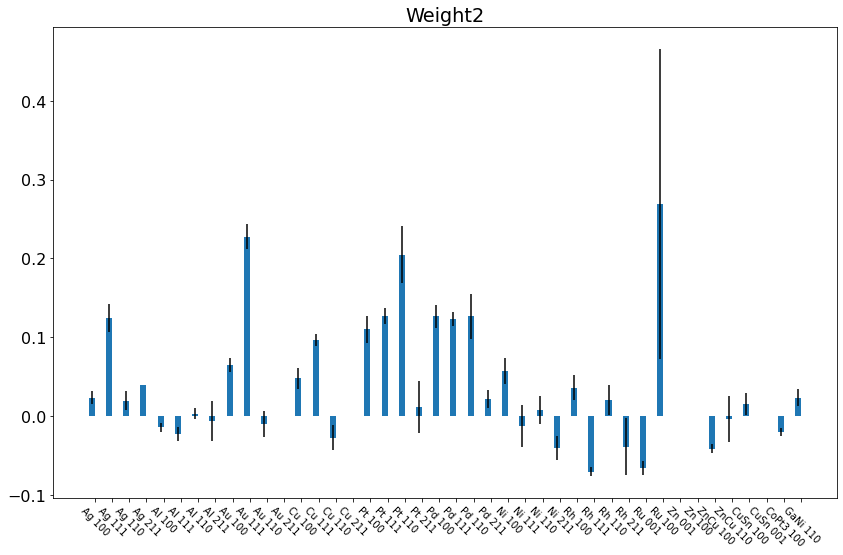

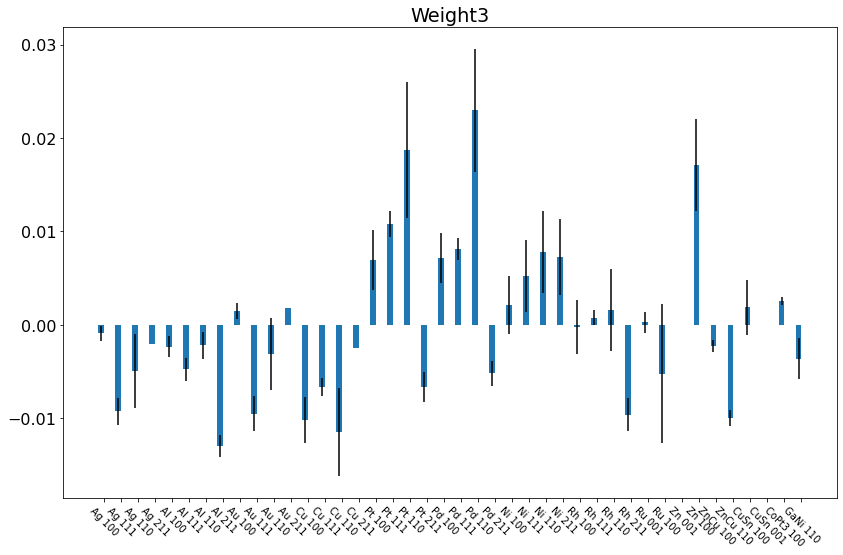

In [11]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, weightslis[:,0], width, yerr = std_errslis[:,0])

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('weight2')
ax.set_title('Weight2')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=-45, fontsize=10)

fig.tight_layout()
plt.width = 10

plt.show()


fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, weightslis[:,1], width, yerr = std_errslis[:,1])

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('weight2')
ax.set_title('Weight3')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=-45, fontsize=10)

fig.tight_layout()
plt.width = 10

plt.show()

### Parameters are only specific to material

Ag 100 0.03184213286300195 0.04870512669495628 -0.005070029504915425 0.010092865534583184 0.001235325521115855
Ag 111 0.0716497648809576 0.04870512669495628 -0.005070029504915425 0.010092865534583184 0.001235325521115855
Ag 110 0.04856104729904112 0.04870512669495628 -0.005070029504915425 0.010092865534583184 0.001235325521115855
Ag 211 0.009725973889224625 0.04870512669495628 -0.005070029504915425 0.010092865534583184 0.001235325521115855
Al 100 0.03235576462814754 -0.005635933507417743 -0.00579067843850395 0.005097851451239729 0.000770640661496969
Al 111 0.03956986118905327 -0.005635933507417743 -0.00579067843850395 0.005097851451239729 0.000770640661496969
Al 110 0.028107711668423054 -0.005635933507417743 -0.00579067843850395 0.005097851451239729 0.000770640661496969
Al 211 0.05239531886601559 -0.005635933507417743 -0.00579067843850395 0.005097851451239729 0.000770640661496969
Au 100 0.05299205393713966 0.14118207371237823 -0.0038672655422925598 0.018955649416605304 0.00235344621946

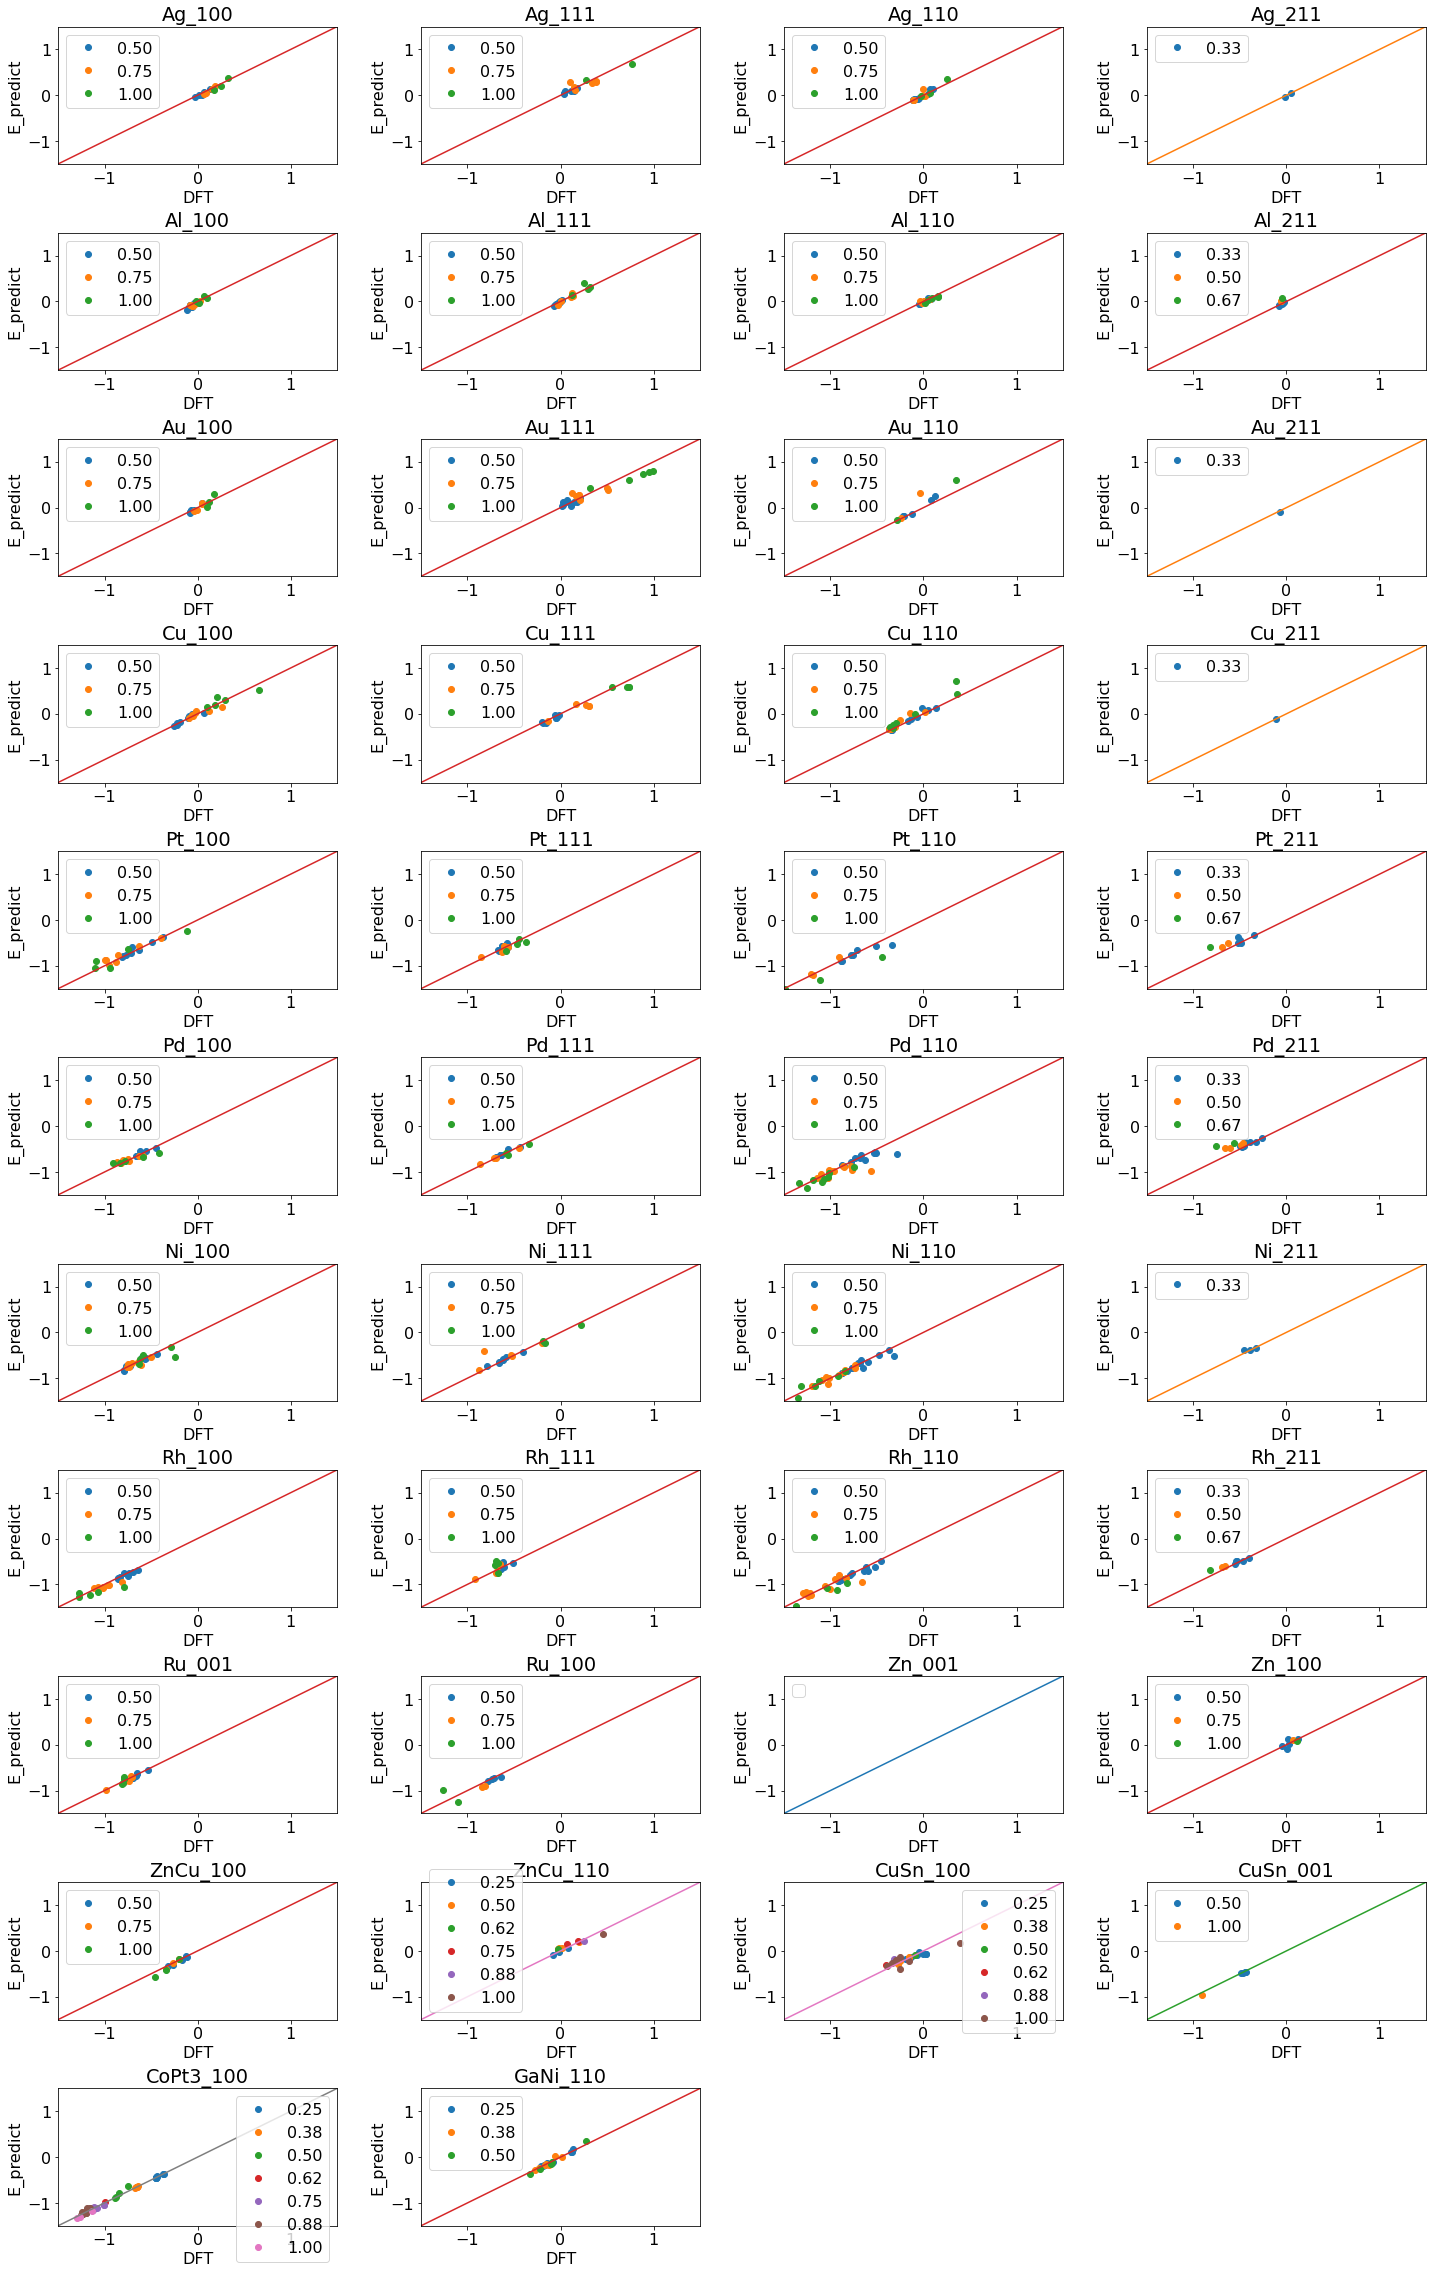

In [12]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(figs[0],figs[1]))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(fign[0],fign[1], i+1)
    xmin = 100
    xmax = -100
#     try:
    weights, std_errs = inst[i].fit_weight_from_specific_formula()
#     except:
#         print('Data unusable')

    for j in range(len(covset[i])):
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        E_residue_pred = data['ads_dist2'] * weights[0] + data['ads_dist3'] * weights[1]
        E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

        aveadsE_suratom = data['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['formula'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_predict')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
    if not covset[i]:
        continue
    data = dfpred[i]
    E_residue_pred = data['ads_dist2'] * weights[0] + data['ads_dist3'] * weights[1]
    E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred
    aveadsE_suratom = data['aveadsE/suratom']    
    print(dictlis[i]['formula'], dictlis[i]['face'], np.sqrt(mean_squared_error(aveadsE_suratom, E_ads_pred)), *weights, *std_errs)

# plt.savefig('E_pred_wm_method2.png', bbox_inches='tight')
# plt.show()

In [13]:
dfall[-5][dfall[-5]['numberofads']==1]

,_id,name,isvalid,ispredictable,formula,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5ef45a5d1fa36aa7694b014f,ZnCu_110_u2_RPBE_no001_CO_n1_d10.traj,yes,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.334788,-60.917344,-14.485436,0.067993,0.008499,0.067993,0.003343,NaN,NaN,51.150813,0.01955,[0],[0],yes,yes,yes,yes,Over 4,0.0,0.000000
1,5ef45a661fa36aa7694b0151,ZnCu_110_u2_RPBE_no002_CO_n1_d10.traj,yes,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.758751,-60.917344,-14.485436,-0.355970,-0.044496,-0.355970,0.003343,NaN,NaN,51.150813,0.01955,[1],[1],yes,yes,yes,yes,Over 4,0.0,0.000000
3,5ef45a781fa36aa7694b0155,ZnCu_110_u2_RPBE_no003_CO_n1_d10.traj,yes,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.099534,-60.917344,-14.485436,0.303246,0.037906,0.303246,0.003343,NaN,NaN,51.150813,0.01955,[2],[2],yes,yes,yes,yes,3,0.0,0.125000
4,5ef45a811fa36aa7694b0157,ZnCu_110_u2_RPBE_no004_CO_n1_d10.traj,no,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.740920,-60.917344,-14.485436,-0.338140,-0.042267,-0.338140,0.003735,NaN,NaN,51.150813,0.01955,[3],[1],yes,yes,no,yes,Over 4,0.0,0.000000
5,5ef45a891fa36aa7694b0159,ZnCu_110_u2_RPBE_no005_CO_n1_d10.traj,yes,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.496489,-60.917344,-14.485436,-0.093708,-0.011714,-0.093708,0.003343,NaN,NaN,51.150813,0.01955,[4],[4],yes,yes,yes,yes,3,0.0,0.125000
6,5ef45a921fa36aa7694b015b,ZnCu_110_u2_RPBE_no006_CO_n1_d10.traj,no,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.735599,-60.917344,-14.485436,-0.332819,-0.041602,-0.332819,0.003646,NaN,NaN,51.150813,0.01955,[5],[1],yes,yes,no,yes,Over 4,0.0,0.000000
7,5ef45a9b1fa36aa7694b015d,ZnCu_110_u2_RPBE_no007_CO_n1_d10.traj,no,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.493520,-60.917344,-14.485436,-0.090740,-0.011342,-0.090740,0.003646,NaN,NaN,51.150813,0.01955,[6],[4],yes,yes,no,yes,3,0.0,0.222222


In [14]:
init_query('ZnCu_110_u2_RPBE_no004_CO_n1_d10.traj','local')
query('ZnCu_110_u2_RPBE_no004_CO_n1_d10.traj','local')

Atoms(symbols='Zn2Cu2Zn2Cu2Zn2Cu2Zn2Cu2Zn2Cu2Zn2Cu2Zn2Cu2Zn2Cu2CO', pbc=[True, True, False], cell=[[6.0140740590921835, 0.0, 4e-16], [1.4e-15, 8.505185099484375, 5e-16], [0.0, 0.0, 25.51555529845313]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27]), calculator=SinglePointCalculator(...))

In [18]:
a = 1
dfall[a]#[dfall[a]['numberofads']==1]

,_id,name,isvalid,ispredictable,formula,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5ef4321a1fa36aa7694af937,Ag_111_u2_RPBE_no001_CO_n1_d9.traj,yes,no,Ag,111,2,RPBE,CO,1,0.25,4,-38.543447,-24.141135,-14.485436,0.083125,0.020781,0.083125,0.002686,NaN,NaN,30.745793,0.032525,[0],[0],yes,yes,yes,yes,Over 4,0.000000,0.000000
1,5ef432211fa36aa7694af939,Ag_111_u2_RPBE_no002_CO_n1_d9.traj,yes,no,Ag,111,2,RPBE,CO,1,0.25,4,-38.520138,-24.141135,-14.485436,0.106433,0.026608,0.106433,0.002686,NaN,NaN,30.745793,0.032525,[1],[1],yes,yes,yes,yes,3,0.000000,0.500000
2,5ef432281fa36aa7694af93b,Ag_111_u2_RPBE_no002_CO_n2_d3.traj,yes,yes,Ag,111,2,RPBE,CO,2,0.50,4,-52.904585,-24.141135,-14.485436,0.207423,0.051856,0.103711,0.242713,0.166249,-0.050385,30.745793,0.065050,"[0, 0]","[0, 0]",yes,yes,yes,yes,3,0.000000,4.000000
3,5ef4322c1fa36aa7694af93d,Ag_111_u2_RPBE_no003_CO_n1_d9.traj,yes,no,Ag,111,2,RPBE,CO,1,0.25,4,-38.526342,-24.141135,-14.485436,0.100229,0.025057,0.100229,0.002635,NaN,NaN,30.745793,0.032525,[2],[2],yes,yes,yes,yes,3,0.000000,0.666667
4,5ef432331fa36aa7694af93f,Ag_111_u2_RPBE_no003_CO_n3_d3.traj,yes,yes,Ag,111,2,RPBE,CO,3,0.75,4,-67.037747,-24.141135,-14.485436,0.559697,0.139924,0.186566,0.752903,0.249374,-0.110645,30.745793,0.097574,"[0, 0, 0]","[0, 0, 0]",yes,yes,yes,yes,3,0.000000,12.000000
5,5ef432381fa36aa7694af941,Ag_111_u2_RPBE_no004_CO_n1_d9.traj,yes,no,Ag,111,2,RPBE,CO,1,0.25,4,-38.533430,-24.141135,-14.485436,0.093141,0.023285,0.093141,0.002634,NaN,NaN,30.745793,0.032525,[3],[3],yes,yes,yes,yes,3,0.000000,0.666667
6,5ef4323c1fa36aa7694af943,Ag_111_u2_RPBE_no004_CO_n4_d3.traj,yes,yes,Ag,111,2,RPBE,CO,4,1.00,4,-80.980724,-24.141135,-14.485436,1.102157,0.275539,0.275539,1.502406,0.332499,-0.183187,30.745793,0.130099,"[0, 0, 0, 0]","[0, 0, 0, 0]",yes,yes,yes,yes,3,0.000000,24.000000
7,5ef432411fa36aa7694af945,Ag_111_u2_RPBE_no005_CO_n3_d3.traj,yes,yes,Ag,111,2,RPBE,CO,3,0.75,4,-67.200132,-24.141135,-14.485436,0.397312,0.099328,0.132437,1.140389,0.272683,-0.253940,30.745793,0.097574,"[1, 0, 0]","[1, 0, 0]",yes,yes,yes,yes,3,0.000000,12.500000
8,5ef432461fa36aa7694af947,Ag_111_u2_RPBE_no006_CO_n4_d3.traj,no,yes,Ag,111,2,RPBE,CO,4,1.00,4,-80.990952,-24.141135,-14.485436,1.091929,0.272982,0.272982,2.307022,0.379116,-0.398552,30.745793,0.130099,"[1, 1, 0, 0]","[1, 1, 0, 0]",no,no,yes,yes,2,1.000000,1.000000
9,5ef4324e1fa36aa7694af949,Ag_111_u2_RPBE_no007_CO_n2_d3.traj,no,yes,Ag,111,2,RPBE,CO,2,0.50,4,-52.947795,-24.141135,-14.485436,0.164213,0.041053,0.082107,0.435073,0.183354,-0.113554,30.745793,0.065050,"[1, 0]","[2, 0]",yes,yes,no,yes,3,0.000000,4.666667
